In [1]:
import sys
sys.path.insert(0,"/workspace/bt")

import yfinance as yf
import matplotlib.pyplot as plt
from strategy import *

%matplotlib inline

bt version :  (0, 2, 10)


In [2]:
# 투자자산
tickers = ['TQQQ','TMF']
# 비교자산,안전자산
dualtickers = ['BND','BIL']

# 월초 리밸런싱
run_on_end_of_period = False
# 지연시간 1일, 하루전 종가 기준으로 리밸런싱
lag = 1
resample_monthly = False

In [3]:
data = yf.download(tickers+dualtickers, end='2022-12-10')['Adj Close']
data = data[tickers+dualtickers]
for c in data.columns:
    print(c, data[c].first_valid_index())
assets = data.dropna().copy()

if resample_monthly:
    assets = assets.resample('M').last().dropna()
    lag = 0
    
start_day = assets.index.min()
print('asset \n', assets)
print('start day : ', start_day)

[*********************100%***********************]  4 of 4 completed
TQQQ 2010-02-11 00:00:00
TMF 2009-04-16 00:00:00
BND 2007-04-10 00:00:00
BIL 2007-05-30 00:00:00
asset 
                  TQQQ        TMF        BND        BIL
Date                                                  
2010-02-11   0.429243   6.660957  55.318848  86.303879
2010-02-12   0.431001   6.736331  55.395752  86.303879
2010-02-16   0.447695   6.796631  55.465694  86.303879
2010-02-17   0.455293   6.579121  55.339825  86.247429
2010-02-18   0.463924   6.467135  55.262928  86.285110
...               ...        ...        ...        ...
2022-12-05  22.115219   9.182485  72.748024  91.179413
2022-12-06  20.712500   9.540632  72.987457  91.209328
2022-12-07  20.463791  10.177337  73.625954  91.209328
2022-12-08  21.190022  10.107697  73.416435  91.269150
2022-12-09  20.782137   9.331713  72.987457  91.259178

[3231 rows x 4 columns]
start day :  2010-02-11 00:00:00


In [4]:
# 매수&보유 백테스트
def long_only_ew(assets, start_day, name='long_only_ew'):
    s = bt.Strategy(name, [bt.algos.RunOnce(),
                           bt.algos.SelectAll(),
                           bt.algos.WeighEqually(),
                           bt.algos.Rebalance()])
    return bt.Backtest(s, assets, initial_capital=100000000.0)

Stat                 benchmark(TQQQ)
-------------------  -----------------
Start                2010-02-11
End                  2022-12-09
Risk-free rate       0.00%

Total Return         4741.57%
Daily Sharpe         0.80
Daily Sortino        1.26
CAGR                 35.33%
Max Drawdown         -80.64%
Calmar Ratio         0.44

MTD                  -11.33%
3m                   -29.99%
6m                   -30.34%
YTD                  -74.88%
1Y                   -74.28%
3Y (ann.)            3.04%
5Y (ann.)            12.63%
10Y (ann.)           34.73%
Since Incep. (ann.)  35.33%

Daily Sharpe         0.80
Daily Sortino        1.26
Daily Mean (ann.)    49.43%
Daily Vol (ann.)     61.42%
Daily Skew           -0.39
Daily Kurt           6.25
Best Day             26.99%
Worst Day            -34.47%

Monthly Sharpe       0.82
Monthly Sortino      1.58
Monthly Mean (ann.)  44.81%
Monthly Vol (ann.)   54.41%
Monthly Skew         -0.09
Monthly Kurt         0.18
Best Month           46.45%
W

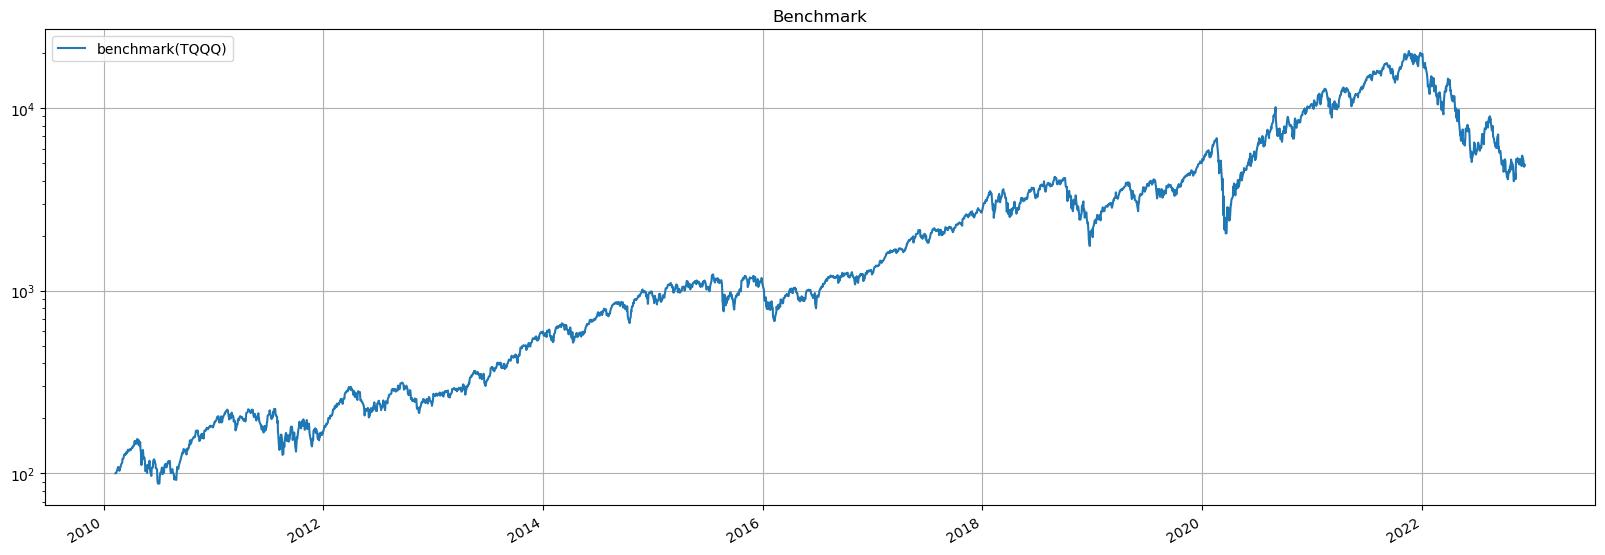

In [5]:
# 벤치마크 수익율
benchmark = long_only_ew(assets[tickers[0]].to_frame(), start_day, 'benchmark({})'.format(tickers[0]))
report = bt.run(benchmark)

report.plot(figsize=(20,7), grid=True, logy=True, title="Benchmark")
print(report.prices[start_day:].calc_stats().display())

In [6]:
def FixedWeight_BT(asset, start_day, weights, run_on_end_of_period=False, lag=1, name='Fixed Weighted'):
    s = bt.Strategy(name, [bt.algos.RunAfterDate(start_day),
                           #bt.algos.RunMonthly(run_on_first_date=False, run_on_end_of_period=run_on_end_of_period, run_on_last_date=False),
                           bt.algos.RunQuarterly(run_on_first_date=False, run_on_end_of_period=run_on_end_of_period, run_on_last_date=False),
                           #bt.algos.PrintInfo('{name}:{now}. Value:{_value:0.0f}, Price:{_price:0.4f}'),
                           #bt.algos.PrintDate(),
                           bt.algos.SelectAll(),
                           bt.algos.WeighSpecified(**weights),
                           #bt.algos.PrintTempData(),
                           bt.algos.Rebalance()])
    return bt.Backtest(s, assets, initial_capital=100000000.0)                           

In [7]:
init=9
fixedWeights = {}
for i in range(0,9):
    weights = {tickers[0]:init/10,tickers[1]:(10-init)/10}
    print(weights)
    fixedWeights[i] = FixedWeight_BT(assets[tickers], start_day, weights, False, lag, name='FW_{}:{}'.format(init,(10-init)))
    init = init - 1
fw_report = bt.run(*fixedWeights.values())

{'TQQQ': 0.9, 'TMF': 0.1}
{'TQQQ': 0.8, 'TMF': 0.2}
{'TQQQ': 0.7, 'TMF': 0.3}
{'TQQQ': 0.6, 'TMF': 0.4}
{'TQQQ': 0.5, 'TMF': 0.5}
{'TQQQ': 0.4, 'TMF': 0.6}
{'TQQQ': 0.3, 'TMF': 0.7}
{'TQQQ': 0.2, 'TMF': 0.8}
{'TQQQ': 0.1, 'TMF': 0.9}


<AxesSubplot:title={'center':'Fixed Weight'}>

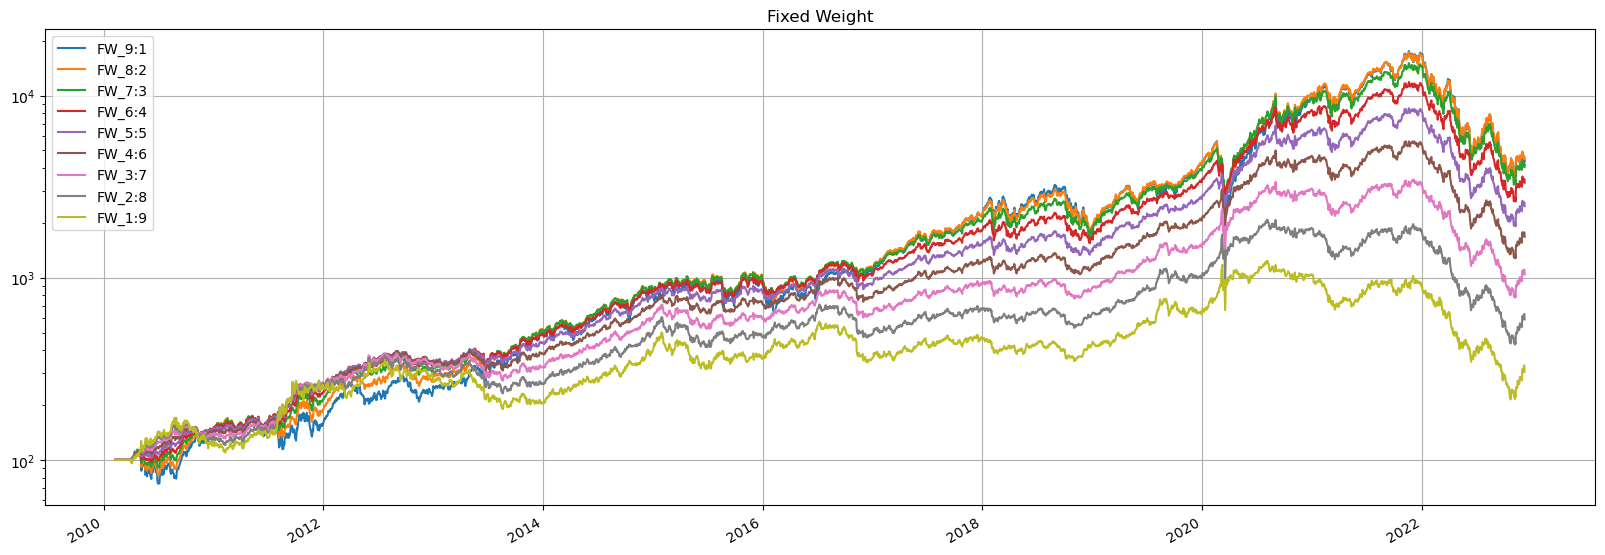

In [8]:
fw_report.plot(figsize=(20,7), grid=True, logy=True, title="Fixed Weight")

In [9]:
fw_report.prices[start_day:]

,FW_9:1,FW_8:2,FW_7:3,FW_6:4,FW_5:5,FW_4:6,FW_3:7,FW_2:8,FW_1:9
2010-02-11,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
2010-02-12,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
2010-02-16,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
2010-02-17,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
2010-02-18,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
...,...,...,...,...,...,...,...,...,...
2022-12-05,4581.431224,4675.682297,4219.689888,3425.271072,2525.756244,1700.884834,1048.027931,590.272818,302.710996
2022-12-06,4335.870677,4471.440897,4077.595264,3344.518439,2491.950389,1695.612735,1055.657823,600.753967,311.286908
2022-12-07,4319.773512,4491.493700,4128.914450,3413.389283,2562.985433,1757.211284,1102.171059,631.816227,329.734818
2022-12-08,4452.450835,4608.601152,4217.936529,3472.001155,2596.047296,1772.572287,1107.343054,632.288887,328.714066


In [10]:
fw_report.prices[start_day:].calc_stats().display()

Stat                 FW_9:1      FW_8:2      FW_7:3      FW_6:4      FW_5:5      FW_4:6      FW_3:7      FW_2:8      FW_1:9
-------------------  ----------  ----------  ----------  ----------  ----------  ----------  ----------  ----------  ----------
Start                2010-02-11  2010-02-11  2010-02-11  2010-02-11  2010-02-11  2010-02-11  2010-02-11  2010-02-11  2010-02-11
End                  2022-12-09  2022-12-09  2022-12-09  2022-12-09  2022-12-09  2022-12-09  2022-12-09  2022-12-09  2022-12-09
Risk-free rate       0.00%       0.00%       0.00%       0.00%       0.00%       0.00%       0.00%       0.00%       0.00%

Total Return         4238.91%    4362.82%    3959.14%    3220.79%    2367.94%    1575.02%    940.22%     490.50%     205.22%
Daily Sharpe         0.83        0.88        0.93        0.95        0.94        0.86        0.73        0.57        0.42
Daily Sortino        1.30        1.39        1.47        1.51        1.48        1.36        1.17        0.93        0.69

In [4]:
start_day2 = start_day + pd.DateOffset(months=12)

In [12]:
# 상대모멘텀 백테스트
def RelativeMomentum_BT(assets, rank, months, start_day, run_on_end_of_period=False, lag=1, name='Relative Momentum'):
    s = bt.Strategy(name, [bt.algos.RunAfterDate(start_day),
                           #bt.algos.RunMonthly(run_on_first_date=False, run_on_end_of_period=run_on_end_of_period, run_on_last_date=False),
                           bt.algos.RunQuarterly(run_on_first_date=False, run_on_end_of_period=run_on_end_of_period, run_on_last_date=False),
                           #bt.algos.PrintInfo('{name}:{now}. Value:{_value:0.0f}, Price:{_price:0.4f}'),
                           #bt.algos.PrintDate(),
                           SelectRelativeMomentum(rank=rank, lookback=pd.DateOffset(months=months), lag=pd.DateOffset(days=lag)),
                           bt.algos.WeighEqually(),
                           #bt.algos.PrintTempData(),
                           bt.algos.Rebalance()])
    return bt.Backtest(s, assets, initial_capital=100000000.0)

In [13]:
# 상대모멘텀 상위 1종목 (1~12개월 비교)
relativemomentum = {}
for i in range(0, 12):
    relativemomentum[i] = RelativeMomentum_BT(assets[tickers], 1, i+1, start_day2, False, lag, name='RM({})'.format(str(i+1)))
    
rm1_report = bt.run(*relativemomentum.values())

<AxesSubplot:title={'center':'Relative Momentum (1~12 month) with rank 1'}>

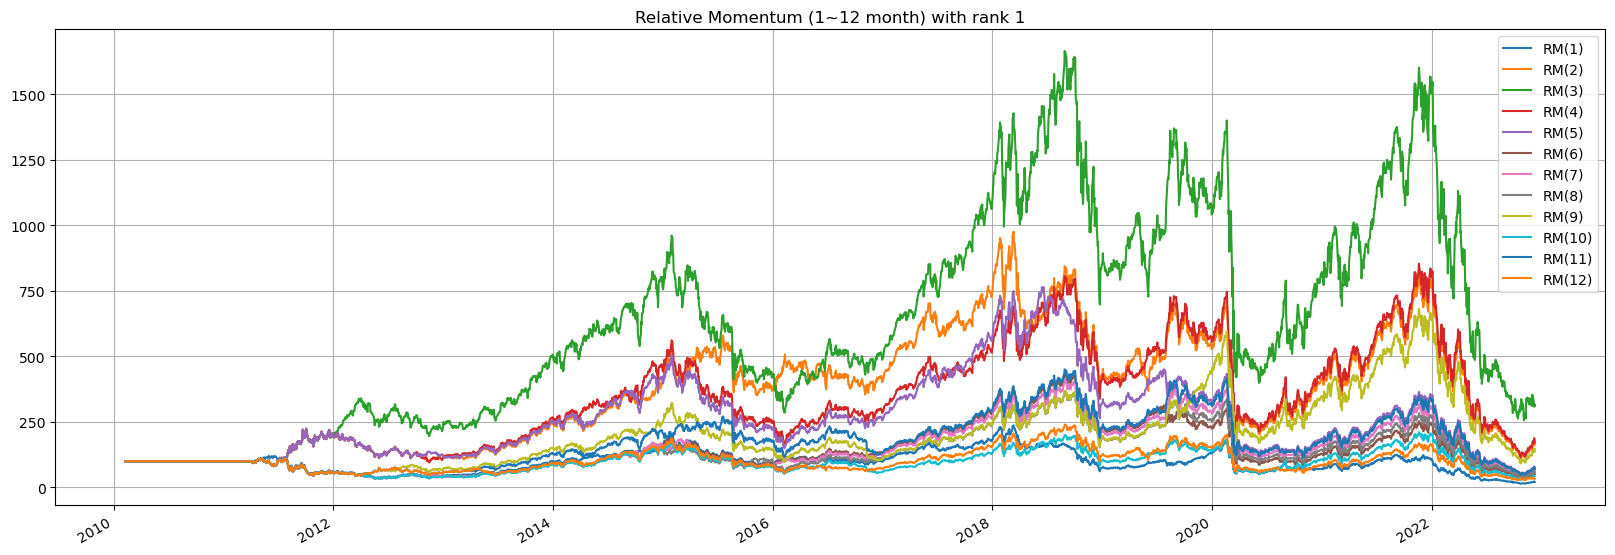

In [14]:
rm1_report.plot(figsize=(20,7), grid=True, title="Relative Momentum (1~12 month) with rank 1")

In [15]:
print(rm1_report.prices[start_day2:].calc_stats().display())

Stat                 RM(1)       RM(2)       RM(3)       RM(4)       RM(5)       RM(6)       RM(7)       RM(8)       RM(9)       RM(10)      RM(11)      RM(12)
-------------------  ----------  ----------  ----------  ----------  ----------  ----------  ----------  ----------  ----------  ----------  ----------  ----------
Start                2011-02-11  2011-02-11  2011-02-11  2011-02-11  2011-02-11  2011-02-11  2011-02-11  2011-02-11  2011-02-11  2011-02-11  2011-02-11  2011-02-11
End                  2022-12-09  2022-12-09  2022-12-09  2022-12-09  2022-12-09  2022-12-09  2022-12-09  2022-12-09  2022-12-09  2022-12-09  2022-12-09  2022-12-09
Risk-free rate       0.00%       0.00%       0.00%       0.00%       0.00%       0.00%       0.00%       0.00%       0.00%       0.00%       0.00%       0.00%

Total Return         -79.06%     63.39%      212.18%     71.87%      -26.63%     -49.07%     -35.86%     -42.93%     37.08%      -57.48%     -29.59%     -67.03%
Daily Sharpe         0.06  

In [20]:
# 절대모멘텀 백테스트
def AbsoluteMomentum_BT(assets, rank, months, start_day, run_on_end_of_period=False, lag=1, name='Absolute Momentum'):
    s = bt.Strategy(name, [bt.algos.RunAfterDate(start_day),
                           bt.algos.RunMonthly(run_on_first_date=False, run_on_end_of_period=run_on_end_of_period, run_on_last_date=False),
                           #bt.algos.PrintInfo('{name}:{now}. Value:{_value:0.0f}, Price:{_price:0.4f}'),
                           #bt.algos.PrintDate(),
                           SelectAbsoluteMomentum(rank=rank, lookback=pd.DateOffset(months=months), lag=pd.DateOffset(days=lag)),
                           bt.algos.WeighEqually(),
                           #bt.algos.PrintTempData(),
                           bt.algos.Rebalance()])
    return bt.Backtest(s, assets, initial_capital=100000000.0)

In [21]:
# 절대모멘텀 상위 1종목 (1~12개월 비교)
absolutemomentum = {}
for i in range(0, 12):   
    absolutemomentum[i] = AbsoluteMomentum_BT(assets[tickers], 1, i+1, start_day2, False, lag, name='AM({})'.format(str(i+1)))
    
am1_report = bt.run(*absolutemomentum.values())

<AxesSubplot:title={'center':'Absolute Momentum(1~12 months) with rank 1'}>

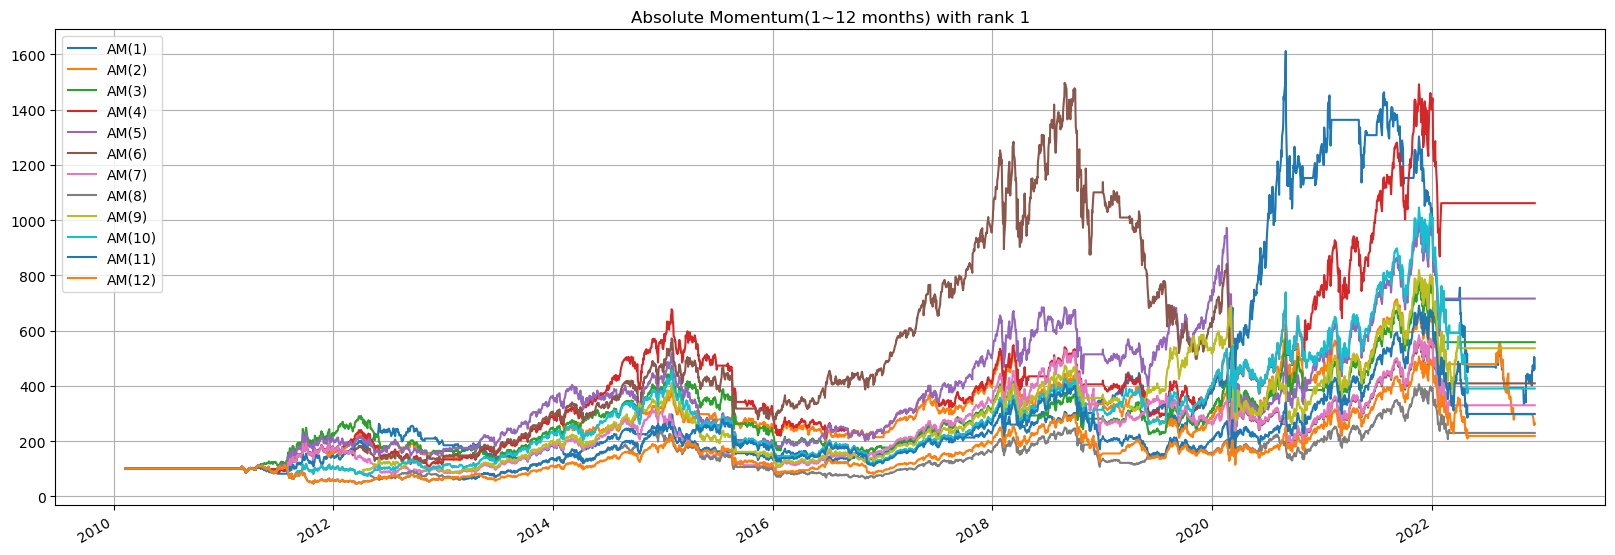

In [22]:
am1_report.plot(figsize=(20,7), grid=True, title='Absolute Momentum(1~12 months) with rank 1')

In [23]:
print(am1_report.prices[start_day:].calc_stats().display())

Stat                 AM(1)       AM(2)       AM(3)       AM(4)       AM(5)       AM(6)       AM(7)       AM(8)       AM(9)       AM(10)      AM(11)      AM(12)
-------------------  ----------  ----------  ----------  ----------  ----------  ----------  ----------  ----------  ----------  ----------  ----------  ----------
Start                2010-02-11  2010-02-11  2010-02-11  2010-02-11  2010-02-11  2010-02-11  2010-02-11  2010-02-11  2010-02-11  2010-02-11  2010-02-11  2010-02-11
End                  2022-12-09  2022-12-09  2022-12-09  2022-12-09  2022-12-09  2022-12-09  2022-12-09  2022-12-09  2022-12-09  2022-12-09  2022-12-09  2022-12-09
Risk-free rate       0.00%       0.00%       0.00%       0.00%       0.00%       0.00%       0.00%       0.00%       0.00%       0.00%       0.00%       0.00%

Total Return         362.81%     161.70%     458.03%     961.31%     615.92%     308.90%     229.57%     129.51%     436.13%     290.18%     198.17%     118.73%
Daily Sharpe         0.49  

In [24]:
# 절대모멘텀 상위 2종목 (1~12개월 비교)
absolutemomentum = {}
for i in range(0, 12):
    absolutemomentum[i] = AbsoluteMomentum_BT(assets[tickers], 2, i+1, start_day2, False, lag, name='AM({})'.format(str(i+1)))
    
am2_report = bt.run(*absolutemomentum.values())

<AxesSubplot:title={'center':'Absolute Momentum (1~12 month) with rank 2'}>

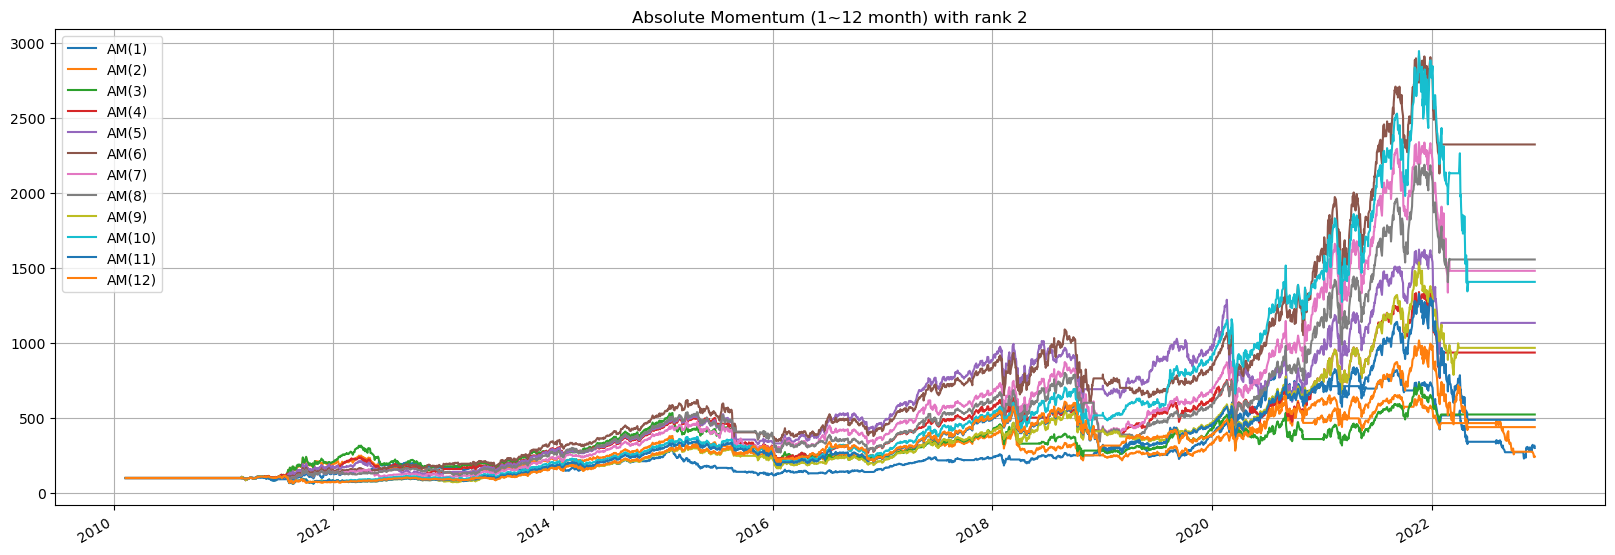

In [25]:
am2_report.plot(figsize=(20,7), grid=True, title='Absolute Momentum (1~12 month) with rank 2')

In [26]:
print(am2_report.prices[start_day2:].calc_stats().display())

Stat                 AM(1)       AM(2)       AM(3)       AM(4)       AM(5)       AM(6)       AM(7)       AM(8)       AM(9)       AM(10)      AM(11)      AM(12)
-------------------  ----------  ----------  ----------  ----------  ----------  ----------  ----------  ----------  ----------  ----------  ----------  ----------
Start                2011-02-11  2011-02-11  2011-02-11  2011-02-11  2011-02-11  2011-02-11  2011-02-11  2011-02-11  2011-02-11  2011-02-11  2011-02-11  2011-02-11
End                  2022-12-09  2022-12-09  2022-12-09  2022-12-09  2022-12-09  2022-12-09  2022-12-09  2022-12-09  2022-12-09  2022-12-09  2022-12-09  2022-12-09
Risk-free rate       0.00%       0.00%       0.00%       0.00%       0.00%       0.00%       0.00%       0.00%       0.00%       0.00%       0.00%       0.00%

Total Return         200.14%     142.69%     423.27%     835.98%     1033.71%    2222.80%    1380.74%    1456.28%    867.39%     1307.03%    387.87%     339.21%
Daily Sharpe         0.43  

In [37]:
# 듀얼모멘텀 백테스트
def DualMomentum_BT(assets, rank, months, start_day, run_on_end_of_period=False, lag=1, name='Dual Momentum'):
    s = bt.Strategy(name, [bt.algos.RunAfterDate(start_day),
                           bt.algos.RunMonthly(run_on_first_date=False, run_on_end_of_period=run_on_end_of_period, run_on_last_date=False),
                           #bt.algos.PrintInfo('{name}:{now}. Value:{_value:0.0f}, Price:{_price:0.4f}'),
                           #bt.algos.PrintDate(),
                           SelectDualMomentum(rank=rank, lookback=pd.DateOffset(months=months), lag=pd.DateOffset(days=lag)),
                           bt.algos.WeighEqually(),
                           #bt.algos.PrintTempData(),
                           bt.algos.Rebalance()])
    return bt.Backtest(s, assets, initial_capital=100000000.0)

In [28]:
# 듀얼모멘텀 상위 1종목 (1~12개월 비교)
dualmomentums = {}
for i in range(0, 12):
    dualmomentums[i] = DualMomentum_BT(assets, 1, i+1, start_day2, False, lag, name='ODM({})'.format(str(i+1)))

dm1_report = bt.run(*dualmomentums.values())

<AxesSubplot:title={'center':'Dual Momentum (1~12 months) with rank 1'}>

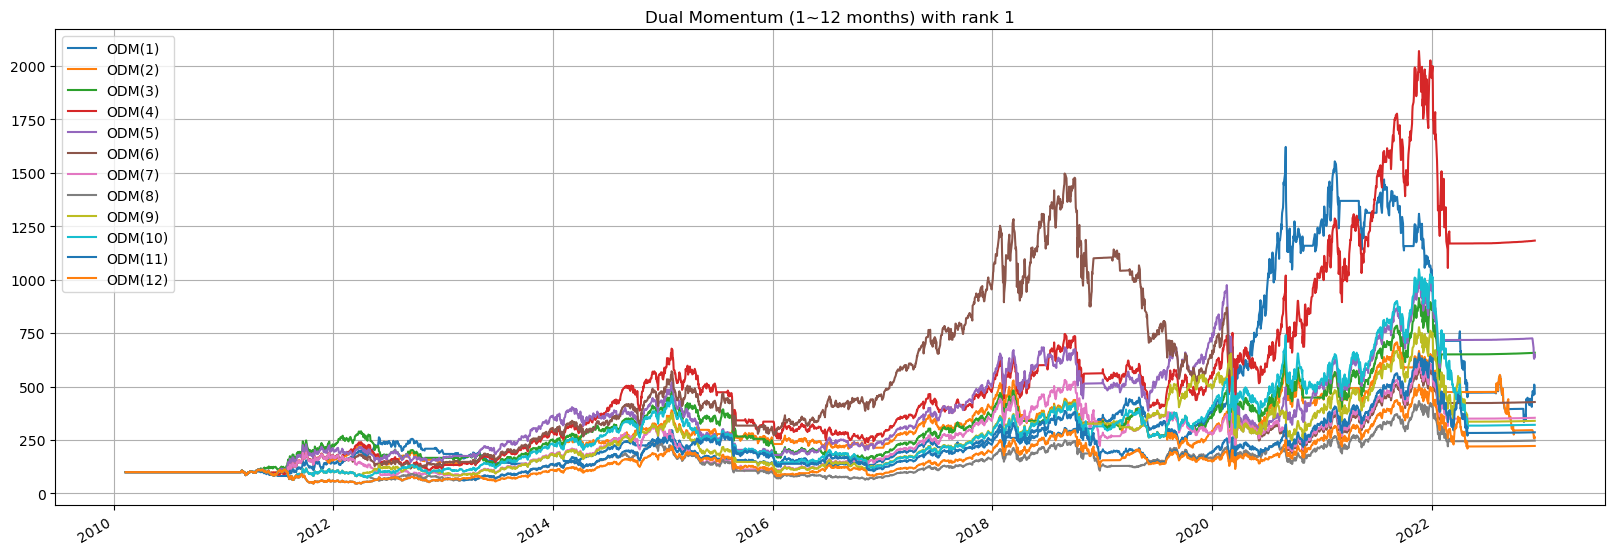

In [29]:
dm1_report.plot(figsize=(20,7), grid=True, title='Dual Momentum (1~12 months) with rank 1')

In [31]:
print(dm1_report.prices[start_day2:].calc_stats().display())

Stat                 ODM(1)      ODM(2)      ODM(3)      ODM(4)      ODM(5)      ODM(6)      ODM(7)      ODM(8)      ODM(9)      ODM(10)     ODM(11)     ODM(12)
-------------------  ----------  ----------  ----------  ----------  ----------  ----------  ----------  ----------  ----------  ----------  ----------  ----------
Start                2011-02-11  2011-02-11  2011-02-11  2011-02-11  2011-02-11  2011-02-11  2011-02-11  2011-02-11  2011-02-11  2011-02-11  2011-02-11  2011-02-11
End                  2022-12-09  2022-12-09  2022-12-09  2022-12-09  2022-12-09  2022-12-09  2022-12-09  2022-12-09  2022-12-09  2022-12-09  2022-12-09  2022-12-09
Risk-free rate       0.00%       0.00%       0.00%       0.00%       0.00%       0.00%       0.00%       0.00%       0.00%       0.00%       0.00%       0.00%

Total Return         366.89%     161.15%     557.89%     1082.29%    539.51%     327.61%     253.87%     147.22%     239.62%     220.84%     186.14%     122.23%
Daily Sharpe         0.52 

In [38]:
# 듀얼모멘텀 상위 2종목 (1~12개월 비교)
dualmomentums = {}
for i in range(0, 12):
    dualmomentums[i] = DualMomentum_BT(assets, 2, i+1, start_day2, False, lag, name='ODM({})'.format(str(i+1)))

dm2_report = bt.run(*dualmomentums.values())

<AxesSubplot:title={'center':'Dual Momentum (1~12 months) with rank 2'}>

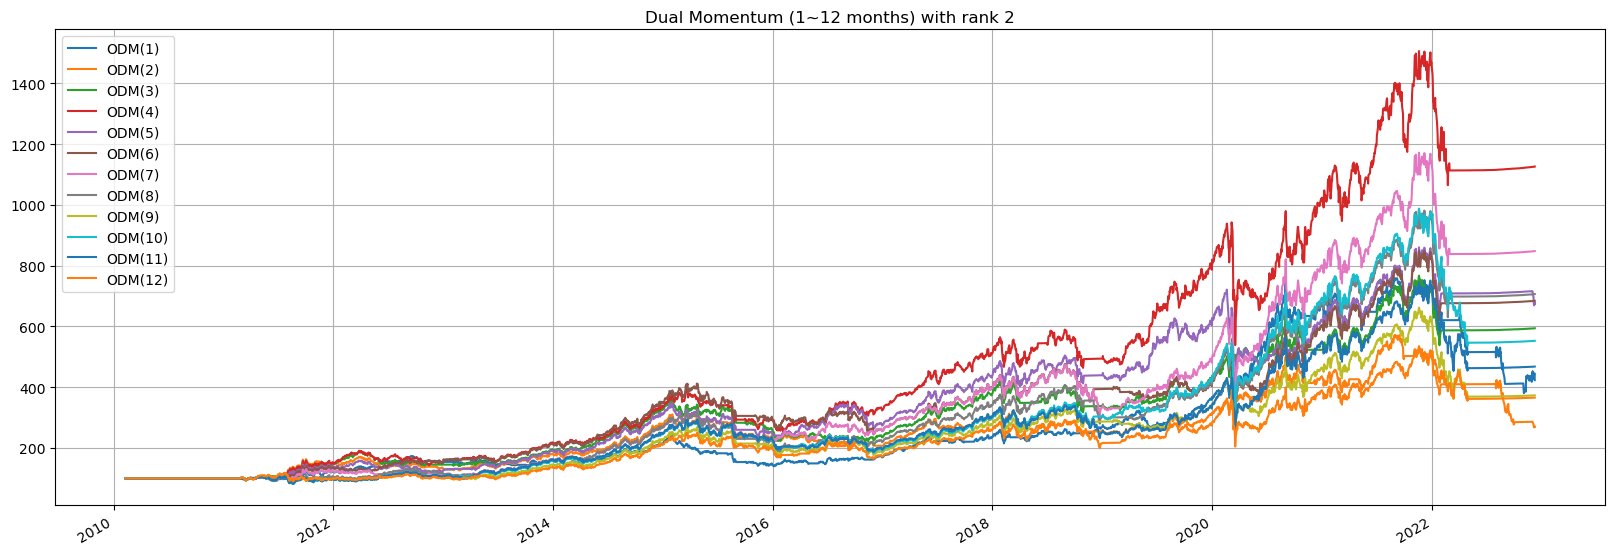

In [39]:
dm2_report.plot(figsize=(20,7), grid=True, title='Dual Momentum (1~12 months) with rank 2')

In [40]:
print(dm2_report.prices[start_day:].calc_stats().display())

Stat                 ODM(1)      ODM(2)      ODM(3)      ODM(4)      ODM(5)      ODM(6)      ODM(7)      ODM(8)      ODM(9)      ODM(10)     ODM(11)     ODM(12)
-------------------  ----------  ----------  ----------  ----------  ----------  ----------  ----------  ----------  ----------  ----------  ----------  ----------
Start                2010-02-11  2010-02-11  2010-02-11  2010-02-11  2010-02-11  2010-02-11  2010-02-11  2010-02-11  2010-02-11  2010-02-11  2010-02-11  2010-02-11
End                  2022-12-09  2022-12-09  2022-12-09  2022-12-09  2022-12-09  2022-12-09  2022-12-09  2022-12-09  2022-12-09  2022-12-09  2022-12-09  2022-12-09
Risk-free rate       0.00%       0.00%       0.00%       0.00%       0.00%       0.00%       0.00%       0.00%       0.00%       0.00%       0.00%       0.00%

Total Return         323.20%     169.40%     493.89%     1026.42%    574.27%     584.35%     748.10%     606.35%     273.03%     452.57%     367.82%     265.59%
Daily Sharpe         0.61 

In [6]:
# 평균모멘텀 스코어 백테스트
def AverageMomentum_BT(assets, start_day, run_on_end_of_period=False, lag=1, cash_weight=0, returns=pd.DataFrame(), ylookback=0, name='Average Momentum'):
    s = bt.Strategy(name, [bt.algos.RunAfterDate(start_day),
                           bt.algos.RunMonthly(run_on_first_date=False, run_on_end_of_period=run_on_end_of_period, run_on_last_date=False),
                           #bt.algos.PrintInfo('{name}:{now}. Value:{_value:0.0f}, Price:{_price:0.4f}'),
                           #bt.algos.PrintDate(),
                           bt.algos.SelectAll(),
                           WeighAMS(lag=lag, cash_weight=cash_weight, returns=returns, ylookback=ylookback),
                           #bt.algos.PrintTempData(),
                           bt.algos.Rebalance()])
    return bt.Backtest(s, assets, initial_capital=100000000.0)

In [7]:
assets_cash = assets[tickers].copy()
# 1년을 252 영업일로 가정
#assets_cash['cash'] = pow(1.03, 1/252)
#assets_cash['cash'] = assets_cash['cash'].shift(1, fill_value=1.0)
#assets_cash['cash'] = assets_cash['cash'].cumprod()
assets_cash['cash'] = assets[dualtickers[1]]
print(assets_cash)

                 UPRO        TMF       cash
Date                                       
2009-06-25   1.173085   7.944012  86.556236
2009-06-26   1.167003   7.989975  86.556236
2009-06-29   1.200113   7.999553  86.556236
2009-06-30   1.171462   7.951674  86.537354
2009-07-01   1.184032   7.865490  86.539253
...               ...        ...        ...
2022-12-06  35.980000   9.590000  91.480003
2022-12-07  35.779999  10.230000  91.480003
2022-12-08  36.599998  10.160000  91.540001
2022-12-09  35.759998   9.380000  91.529999
2022-12-12  37.299999   9.460000  91.540001

[3391 rows x 3 columns]


In [8]:
# 평균모멘텀 
averagemomentums = {}
cash_weights = [0, 0.3, 0.6]
for i in range(0, len(cash_weights)):
    averagemomentums[i] = AverageMomentum_BT(assets_cash, start_day, False, lag, cash_weights[i], pd.DataFrame(), 0, 'AMS_CASH({})'.format(cash_weights[i]))
    
avg_report = bt.run(*averagemomentums.values())

selected 
 ['UPRO', 'TMF', 'cash']
item[1]=0.08333333333333333, child=UPRO, base=100000000.0
item[1]=0.5, child=TMF, base=100000000.0
item[1]=0.41666666666666663, child=cash, base=100000000.0
selected 
 ['UPRO', 'TMF', 'cash']
item[1]=0.2916666666666667, child=UPRO, base=98332338.79550552
item[1]=0.4583333333333333, child=TMF, base=98332338.79550552
item[1]=0.25, child=cash, base=98332338.79550552
selected 
 ['UPRO', 'TMF', 'cash']
item[1]=0.08333333333333333, child=UPRO, base=105059086.7617892
item[1]=0.5, child=TMF, base=105059086.7617892
item[1]=0.41666666666666663, child=cash, base=105059086.7617892
selected 
 ['UPRO', 'TMF', 'cash']
item[1]=0.4166666666666667, child=UPRO, base=104614045.40353692
item[1]=0.4583333333333333, child=TMF, base=104614045.40353692
item[1]=0.125, child=cash, base=104614045.40353692
selected 
 ['UPRO', 'TMF', 'cash']
item[1]=0.4166666666666667, child=UPRO, base=102798599.63170445
item[1]=0.3333333333333333, child=TMF, base=102798599.63170445
item[1]=0.25, 

<AxesSubplot:title={'center':'Average Momentum'}>

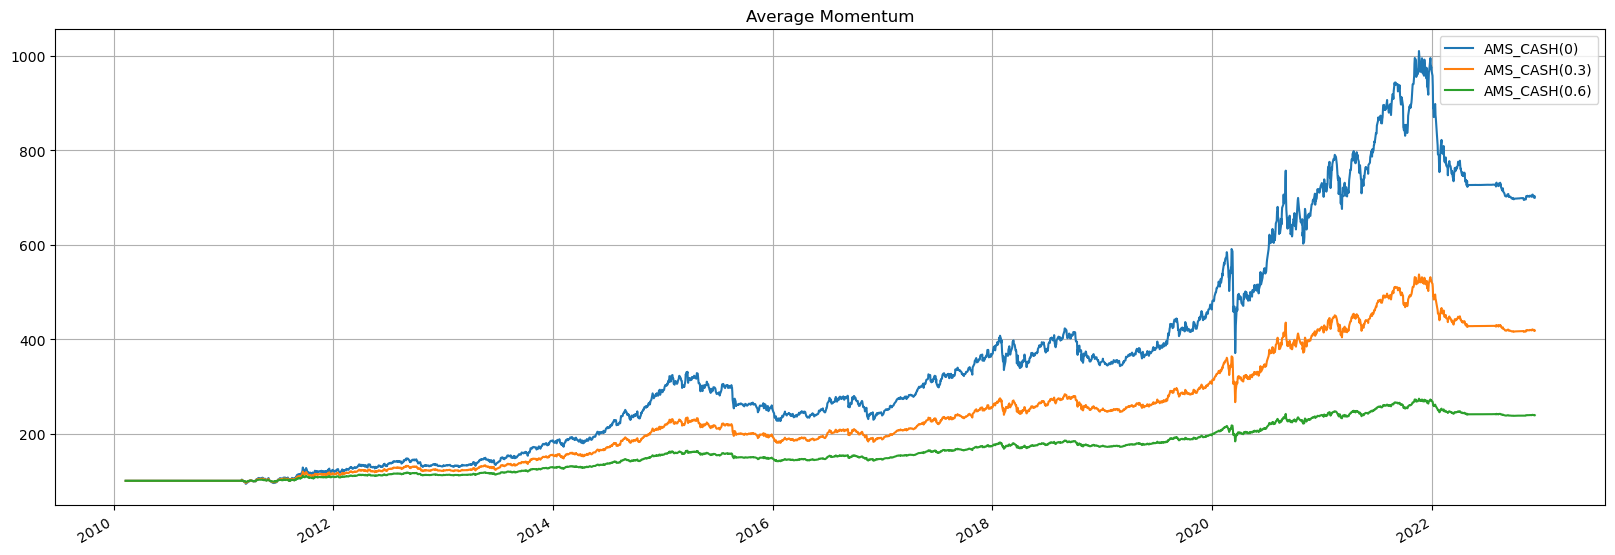

In [31]:
avg_report.plot(figsize=(20,7), grid=True, title='Average Momentum')

In [32]:
avg_report.prices[start_day:].calc_stats().display()

Stat                 AMS_CASH(0)    AMS_CASH(0.3)    AMS_CASH(0.6)
-------------------  -------------  ---------------  ---------------
Start                2011-02-10     2011-02-10       2011-02-10
End                  2022-12-09     2022-12-09       2022-12-09
Risk-free rate       0.00%          0.00%            0.00%

Total Return         599.80%        318.05%          138.98%
Daily Sharpe         0.84           0.85             0.87
Daily Sortino        1.30           1.31             1.34
CAGR                 17.88%         12.86%           7.64%
Max Drawdown         -37.30%        -26.69%          -15.57%
Calmar Ratio         0.48           0.48             0.49

MTD                  -0.80%         -0.52%           -0.24%
3m                   -0.91%         -0.41%           0.08%
6m                   -3.69%         -2.26%           -0.83%
YTD                  -27.68%        -19.73%          -11.19%
1Y                   -27.42%        -19.53%          -11.06%
3Y (ann.)          

<AxesSubplot:>

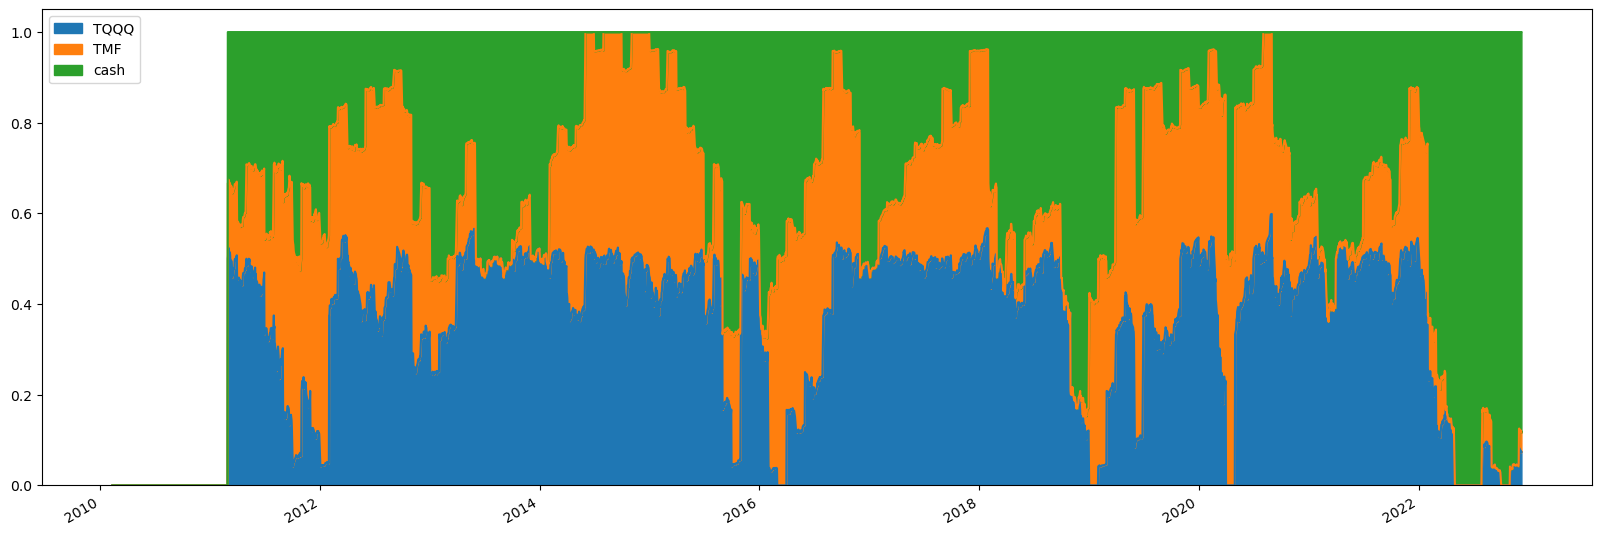

In [33]:
avg_report.get_security_weights().plot.area(figsize=(20,7))

In [34]:
# 수익률곡선+평균모멘텀
yieldcurve = avg_report.prices['AMS_CASH(0)'].rebase(1).to_frame().copy()
yams = {}
lookbacks = [2,3,4,5,6,7,8,9,10,11,12]
for i in range(0,11):
    yams[i] = AverageMomentum_BT(assets_cash, start_day, False, lag, 0, yieldcurve, lookbacks[i], 'yAMS_{}'.format(str(lookbacks[i])))

yams_report = bt.run(*yams.values())

<AxesSubplot:title={'center':'Yield Curve Momentum'}>

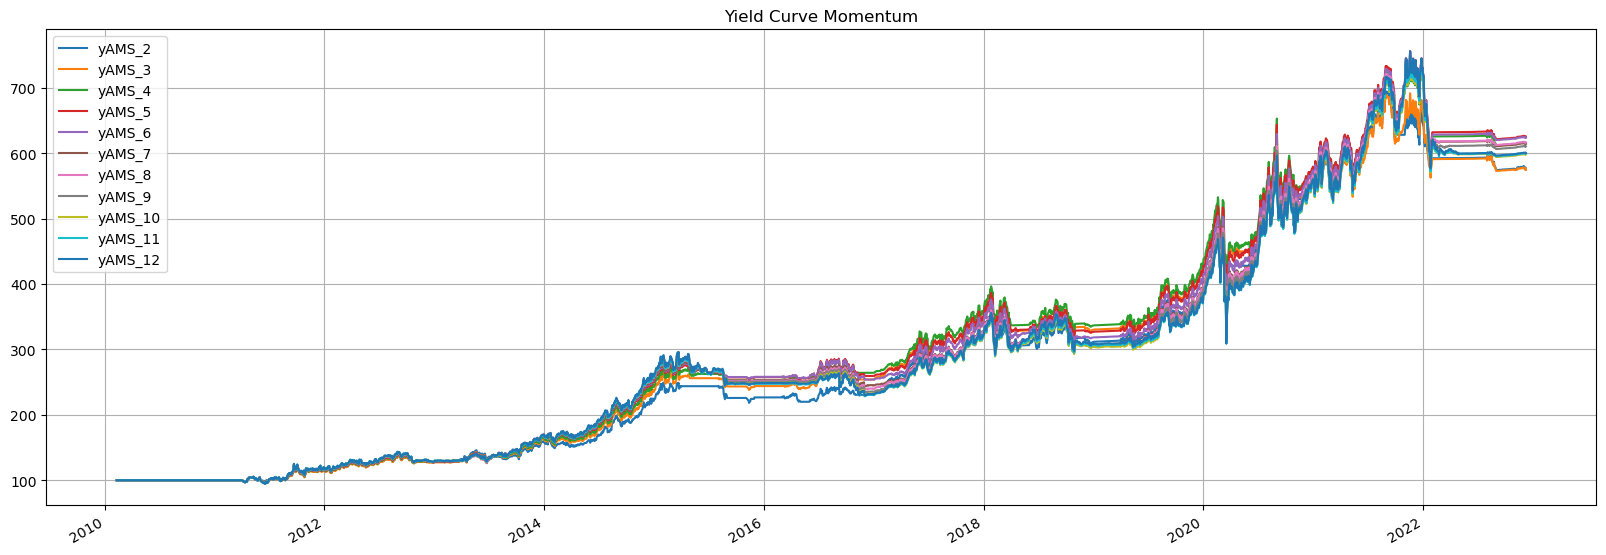

In [35]:
yams_report.plot(figsize=(20,7), grid=True, title='Yield Curve Momentum')

In [36]:
yams_report.prices[start_day:].calc_stats().display()

Stat                 yAMS_2      yAMS_3      yAMS_4      yAMS_5      yAMS_6      yAMS_7      yAMS_8      yAMS_9      yAMS_10     yAMS_11     yAMS_12
-------------------  ----------  ----------  ----------  ----------  ----------  ----------  ----------  ----------  ----------  ----------  ----------
Start                2011-02-10  2011-02-10  2011-02-10  2011-02-10  2011-02-10  2011-02-10  2011-02-10  2011-02-10  2011-02-10  2011-02-10  2011-02-10
End                  2022-12-09  2022-12-09  2022-12-09  2022-12-09  2022-12-09  2022-12-09  2022-12-09  2022-12-09  2022-12-09  2022-12-09  2022-12-09
Risk-free rate       0.00%       0.00%       0.00%       0.00%       0.00%       0.00%       0.00%       0.00%       0.00%       0.00%       0.00%

Total Return         475.09%     474.97%     514.71%     524.67%     523.56%     514.37%     516.35%     510.23%     498.04%     499.33%     500.43%
Daily Sharpe         0.97        0.94        0.94        0.93        0.92        0.90        0.89 

In [37]:
# 변동성역가중 백테스트(일간데이터)
def WeighInvVol_BT(assets, months, start_day, run_on_end_of_period=False, lag=1, name='Inverse Volatility'):
    s = bt.Strategy(name, [bt.algos.RunAfterDate(start_day),
                           bt.algos.RunMonthly(run_on_first_date=False, run_on_end_of_period=run_on_end_of_period, run_on_last_date=False),
                           #bt.algos.PrintInfo('{name}:{now}. Value:{_value:0.0f}, Price:{_price:0.4f}'),
                           #bt.algos.PrintDate(),
                           bt.algos.SelectAll(),
                           bt.algos.WeighInvVol(lookback=pd.DateOffset(months=months), lag=pd.DateOffset(days=lag)),
                           #bt.algos.PrintTempData(),
                           bt.algos.Rebalance()])
    return bt.Backtest(s, assets, initial_capital=100000000.0)

In [38]:
# 변동성역가중 백테스트(12개월 월간 데이터)
def WeighInvVol_12_BT(assets, start_day, run_on_end_of_period=False, lag=1, returns=pd.DataFrame(), ylookback=0, name='Inverse Volatility'):
    s = bt.Strategy(name, [bt.algos.RunAfterDate(start_day),
                           bt.algos.RunMonthly(run_on_first_date=False, run_on_end_of_period=run_on_end_of_period, run_on_last_date=False),
                           #bt.algos.PrintInfo('{name}:{now}. Value:{_value:0.0f}, Price:{_price:0.4f}'),
                           #bt.algos.PrintDate(),
                           bt.algos.SelectAll(),
                           WeighInvVol_12(lag=lag, returns=returns, ylookback=ylookback),
                           #bt.algos.PrintTempData(),
                           bt.algos.Rebalance()])
    return bt.Backtest(s, assets, initial_capital=100000000.0)

In [39]:
# 변동성 역가중(일간, 월간) 반추기간 12개월
ivds = {}
for i in range(0,12):
    ivds[i] = WeighInvVol_BT(assets[tickers], i+1, start_day, False, lag, name='IVD_{}M'.format(str(i+1)))
ivm = WeighInvVol_12_BT(assets[tickers], start_day, False, lag, pd.DataFrame(), 0, name='IVM')
iv_report = bt.run(ivm, *ivds.values())

<AxesSubplot:title={'center':'Inverse Volatility'}>

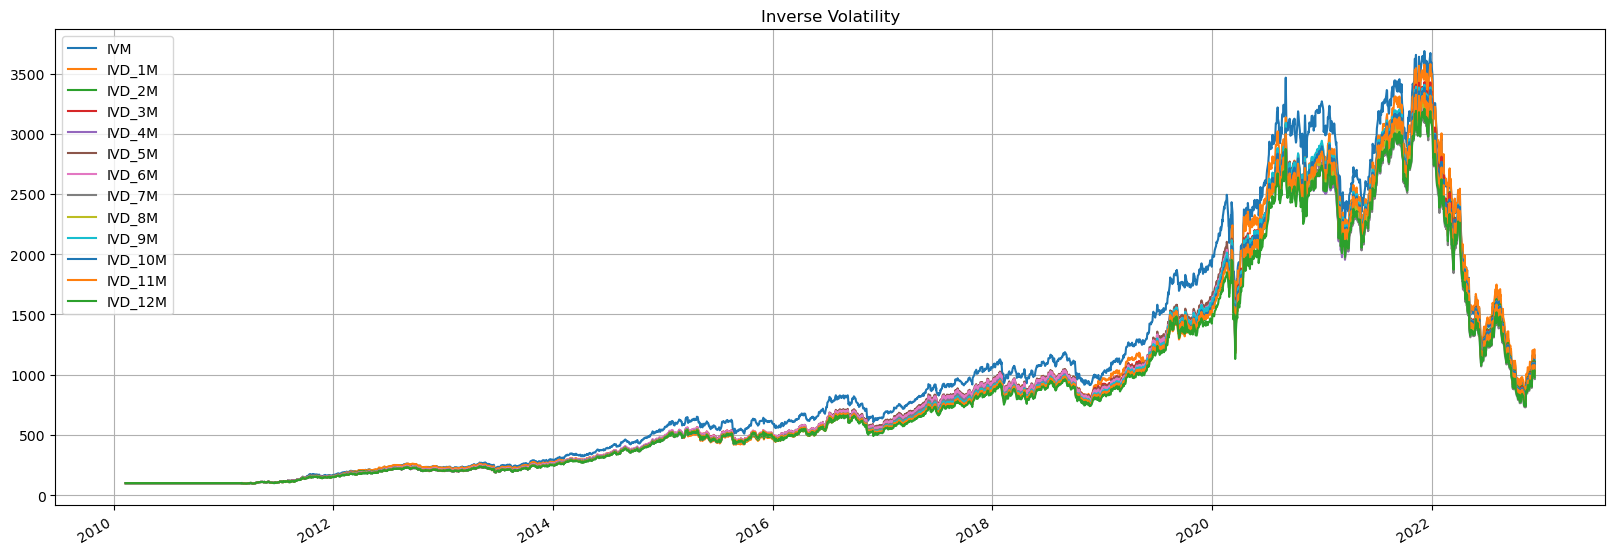

In [40]:
iv_report.plot(figsize=(20,7), grid=True, title='Inverse Volatility')

In [41]:
#iv_report.prices[start_day:].calc_stats().display()
iv_report.set_date_range(start_day)
iv_report.display()

Stat                 IVM         IVD_1M      IVD_2M      IVD_3M      IVD_4M      IVD_5M      IVD_6M      IVD_7M      IVD_8M      IVD_9M      IVD_10M     IVD_11M     IVD_12M
-------------------  ----------  ----------  ----------  ----------  ----------  ----------  ----------  ----------  ----------  ----------  ----------  ----------  ----------
Start                2011-02-10  2011-02-10  2011-02-10  2011-02-10  2011-02-10  2011-02-10  2011-02-10  2011-02-10  2011-02-10  2011-02-10  2011-02-10  2011-02-10  2011-02-10
End                  2022-12-09  2022-12-09  2022-12-09  2022-12-09  2022-12-09  2022-12-09  2022-12-09  2022-12-09  2022-12-09  2022-12-09  2022-12-09  2022-12-09  2022-12-09
Risk-free rate       0.00%       0.00%       0.00%       0.00%       0.00%       0.00%       0.00%       0.00%       0.00%       0.00%       0.00%       0.00%       0.00%

Total Return         999.66%     1040.22%    951.03%     940.28%     899.58%     925.87%     906.55%     864.20%     906.48%   

In [42]:
# 수익률곡선+변동성 역가중(월간) 반추기간 12개월
yieldcurve = iv_report.prices['IVD_1M'].rebase(1).to_frame().copy()
yivms = {}
lookbacks = [2,3,4,5,6,7,8,9,10,11,12]
for i in range(0,11):
    yivms[i] = WeighInvVol_12_BT(assets_cash, start_day, False, lag, yieldcurve, lookbacks[i], name='yIVM_{}M'.format(str(lookbacks[i])))
yivms_report = bt.run(*yivms.values())

<AxesSubplot:title={'center':'IVM_Y'}>

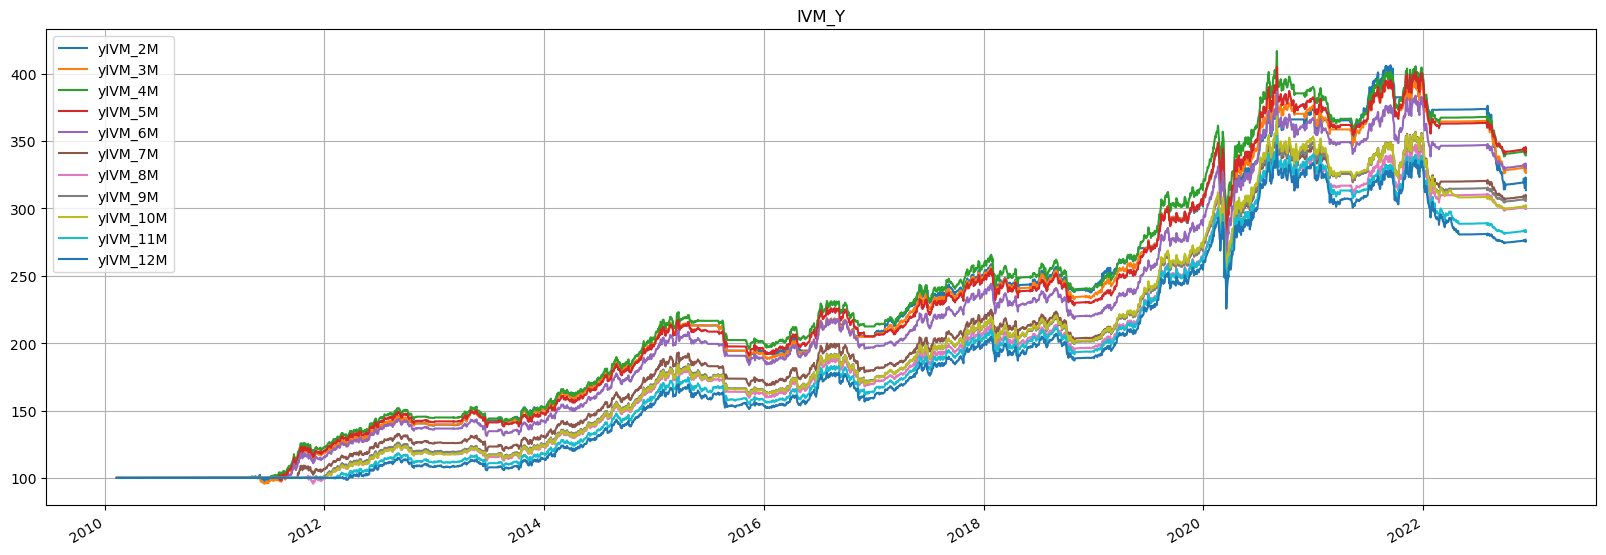

In [43]:
yivms_report.plot(figsize=(20,7), grid=True, title='IVM_Y')

In [44]:
yivms_report.set_date_range(start_day)
yivms_report.display()

Stat                 yIVM_2M     yIVM_3M     yIVM_4M     yIVM_5M     yIVM_6M     yIVM_7M     yIVM_8M     yIVM_9M     yIVM_10M    yIVM_11M    yIVM_12M
-------------------  ----------  ----------  ----------  ----------  ----------  ----------  ----------  ----------  ----------  ----------  ----------
Start                2011-02-10  2011-02-10  2011-02-10  2011-02-10  2011-02-10  2011-02-10  2011-02-10  2011-02-10  2011-02-10  2011-02-10  2011-02-10
End                  2022-12-09  2022-12-09  2022-12-09  2022-12-09  2022-12-09  2022-12-09  2022-12-09  2022-12-09  2022-12-09  2022-12-09  2022-12-09
Risk-free rate       0.00%       0.00%       0.00%       0.00%       0.00%       0.00%       0.00%       0.00%       0.00%       0.00%       0.00%

Total Return         213.53%     226.31%     239.34%     241.52%     230.07%     207.41%     199.63%     205.74%     200.66%     182.52%     175.51%
Daily Sharpe         0.94        0.98        1.01        1.01        1.00        0.94        0.93

In [4]:
# 가속듀얼모멘텀 백테스트
def WeighADM_BT(assets, rank, start_day, run_on_end_of_period=False, lag=1, name='Accelerating DM'):
    s = bt.Strategy(name, [bt.algos.RunAfterDate(start_day),
                           bt.algos.RunMonthly(run_on_first_date=False, run_on_end_of_period=run_on_end_of_period, run_on_last_date=False),
                           #bt.algos.PrintInfo('{name}:{now}. Value:{_value:0.0f}, Price:{_price:0.4f}'),
                           #bt.algos.PrintDate(),
                           bt.algos.SelectAll(),
                           WeighADM(rank=rank, lag=pd.DateOffset(days=lag)),
                           #bt.algos.PrintTempData(),
                           bt.algos.Rebalance()])
    return bt.Backtest(s, assets, initial_capital=100000000.0)

In [5]:
# 가속 듀얼모멘텀 1~2종목
assets_adm = assets[tickers].copy()
assets_adm[dualtickers[1]] = assets[dualtickers[1]]
          
adms = {}
for i in range(0,2):
    adms[i] = WeighADM_BT(assets_adm, i+1, start_day, False, lag, name='ADM_{}R'.format(str(i+1)))
adm_report = bt.run(*adms.values())

<AxesSubplot:title={'center':'ADM (1~2) ranks'}>

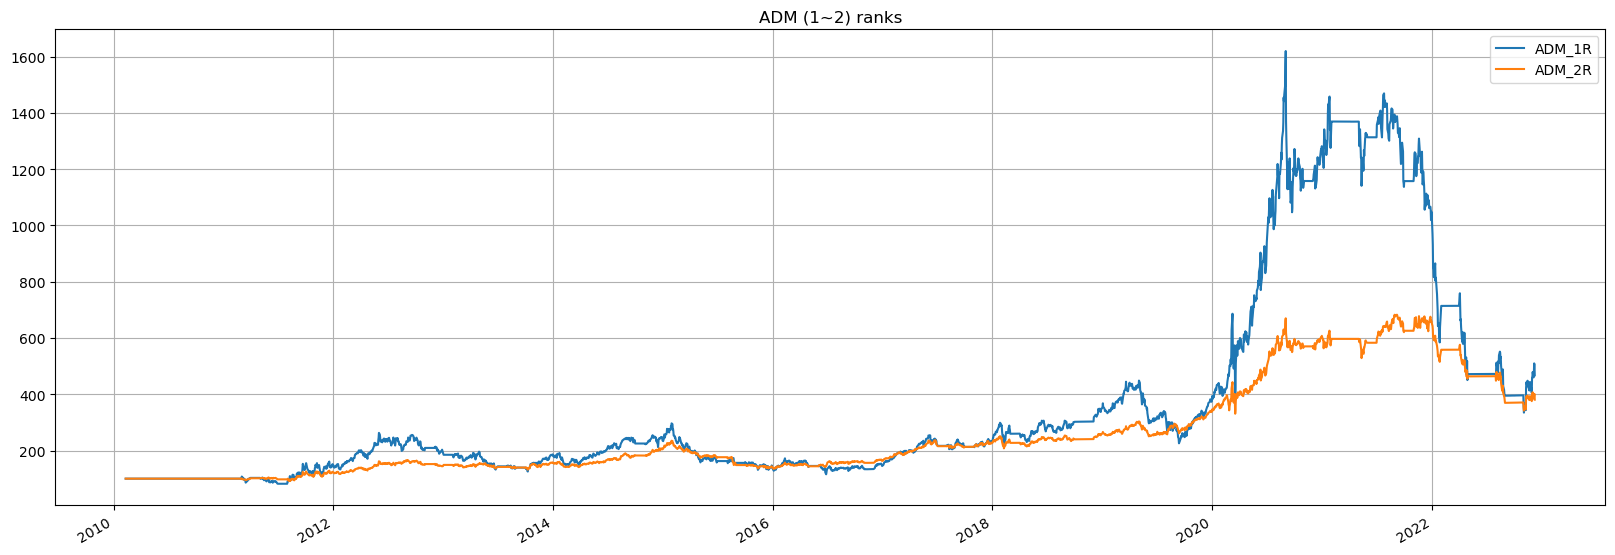

In [6]:
adm_report.plot(figsize=(20,7), grid=True, title='ADM (1~2) ranks')

In [7]:
adm_report.set_date_range(start_day)
adm_report.display()

Stat                 ADM_1R      ADM_2R
-------------------  ----------  ----------
Start                2011-02-10  2011-02-10
End                  2022-12-09  2022-12-09
Risk-free rate       0.00%       0.00%

Total Return         367.37%     280.78%
Daily Sharpe         0.52        0.60
Daily Sortino        0.80        0.93
CAGR                 13.92%      11.97%
Max Drawdown         -79.34%     -49.88%
Calmar Ratio         0.18        0.24

MTD                  1.64%       -5.08%
3m                   18.32%      3.00%
6m                   -0.97%      -17.90%
YTD                  -55.44%     -41.92%
1Y                   -56.56%     -41.88%
3Y (ann.)            12.14%      6.36%
5Y (ann.)            15.49%      11.11%
10Y (ann.)           8.30%       9.75%
Since Incep. (ann.)  13.92%      11.97%

Daily Sharpe         0.52        0.60
Daily Sortino        0.80        0.93
Daily Mean (ann.)    23.53%      14.15%
Daily Vol (ann.)     45.65%      23.76%
Daily Skew           -0.16       -